In [1]:
import re
import os 
from glob import glob
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy import integrate
from scipy import interpolate
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter1d

# Data cleaning, all in SI units

# Not in use this time as the data is ready in SI units

   Corrected P  Drive Voltage     E_SI  Measured Polarization  P from R  \
0    -2.047388        -7.0190 -28076.0              -2.213653 -0.166265   
1    -2.043513        -2.8229 -11291.6              -2.209801 -0.166288   
2    -2.036145         3.5095  14038.0              -2.202431 -0.166286   
3    -2.028109        -1.2207  -4882.8              -2.194390 -0.166281   
4    -2.023924         2.6703  10681.2              -2.190202 -0.166277   

       P_SI  Time (ms)  
0 -0.020474       0.05  
1 -0.020435       0.10  
2 -0.020361       0.15  
3 -0.020281       0.20  
4 -0.020239       0.25  
#--------------------------below is after interting columns of P_SI AND E_SI0---------------------------------------#
   Corrected P  Drive Voltage     E_SI  Measured Polarization  P from R  \
0    -2.047388        -7.0190 -28076.0              -2.213653 -0.166265   
1    -2.043513        -2.8229 -11291.6              -2.209801 -0.166288   
2    -2.036145         3.5095  14038.0              -2.2

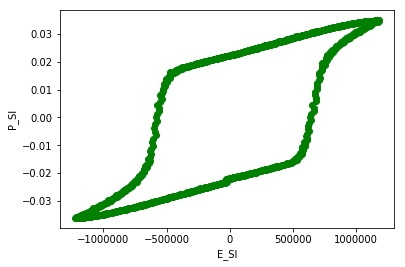

In [16]:
# path = 'C:\\PhD-Zipeng\\Research projects\\PUND\\BF4 PUND PE Heating\\PECorrected'
# output_path = 'C:\\PhD-Zipeng\\Research projects\\DABCO\\BF4\\No16_2x42mm2_250um\\PUND indirect\\PE'


df = pd.read_csv(r'C:\\PhD-Zipeng\\Research projects\\DABCO\\BF4\\No16_PUND\\360.05.csv',encoding= 'unicode_escape')
print(df.head(5))
#删除以前的错误 P_Si 和 E_SI 列，避免混乱
# df.drop(['P_SI'],axis=1,inplace=True)
# df.drop(['E_SI'],axis=1,inplace=True)
# print(df.head(5))

# convert P into C/m^2
# convert E into V/m
thickness = 250 # unit in micro-metre

# P_SI  = df['Corrected P']*0.01
# E_SI  = df['#Drive Voltage']/(thickness*0.000001)

# df.insert(len(df.columns), "E_SI", E_SI)
# df.insert(len(df.columns), "P_SI", P_SI)

print('#--------------------------below is after interting columns of P_SI AND E_SI0---------------------------------------#')
print(df.head(5))
print('#-------------------------------------------------------------------------------------------------------------------#')
plt.plot(df['E_SI'],0.01*df['Measured Polarization'],'go--')
plt.xlabel('E_SI')
plt.ylabel('P_SI')
plt.show()

In [6]:
## 批量操作所有文件

path = 'C:\\PhD-Zipeng\\Research projects\\PUND\\BF4 PUND PE Heating\\PECorrected'
output_path = 'C:\\PhD-Zipeng\\Research projects\\DABCO\\BF4\\No16_2x42mm2_250um\\PUND indirect\\Raw data_SI units'
files = glob(path + "/*.csv")
thickness = 250 # unit in micro-metre
i = 0

for file in files:
    df = pd.read_csv(file,delimiter='\,')
    df.drop(['P_SI'],axis=1,inplace=True)
    df.drop(['E_SI'],axis=1,inplace=True)

    P_SI  = df['Corrected P']*0.01
    E_SI  = df['#Drive Voltage']/(thickness*0.000001)

    df.insert(len(df.columns), "E_SI", E_SI)
    df.insert(len(df.columns), "P_SI", P_SI)
    
    file_name = output_path +'\\'+ str(temperature[i])+'.csv'
    
    df.to_csv(file_name, index=None)
    i = i+1

C:\Users\Dev\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


### 如果上面的loop无法运行，用这个cell 来 debug（一般问题是 csv读取格式/ delimiter 用逗号还是空格）
path = 'C:\\PhD-Zipeng\\Research projects\\PUND\\BF4 PUND PE Heating\\PECorrected\\359.93.csv'
output_path = 'C:\\PhD-Zipeng\\Research projects\\DABCO\\BF4\\No16_2x42mm2_250um\\PUND indirect\\Raw data_SI units'
files = glob(path + "/*.csv")
thickness = 250 # unit in micro-metre
df = pd.read_csv(file,delimiter='\,')
df.head(5)

# Resolve PE and find upper-branch

251
750


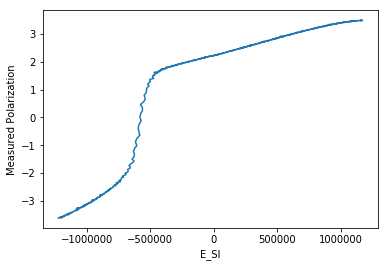

,E_SI,Measured Polarization
251,1167602.4,3.493652
252,1162719.6,3.492479
253,1171570.0,3.492982
254,1158752.4,3.490804
255,1151123.2,3.489966


In [20]:
# plt.plot(df['Measured Polarization'])
# plt.xlabel('rows')
# plt.ylabel('Measured Polarization')
# plt.show()
index1 = df['Measured Polarization'].idxmax()
index2 = df['Measured Polarization'].idxmin()
print(index1)
print(index2)

###提取特定的行列，构成 P_upper_branch
# P_upper = df[index1:index2]
P_upper = df.loc[index1:index2, [ 'E_SI','Measured Polarization']]
# print(P_upper)
plt.plot(P_upper['E_SI'],P_upper['Measured Polarization'])
plt.xlabel('E_SI')
plt.ylabel('Measured Polarization')
plt.show()
P_upper.head(5)

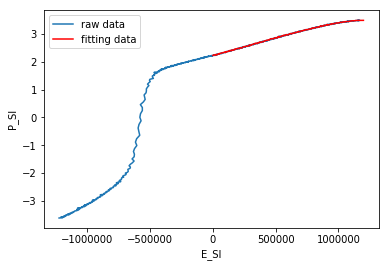

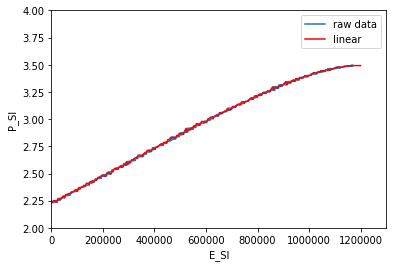

In [22]:
### https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html
### 根据实验数据，插点 得到 P_SI, E_SI。 这一步的目的是为了之后 求 P（T），使得所有的 P（E）数据点对齐
x = P_upper['E_SI']
y = P_upper['Measured Polarization']

## 如果需要 ， 可以smooth data！！！！！

# y = savgol_filter(P_upper['P_SI'], 21, 1)
# plt.plot(x, y)
# plt.show()
         
f = interp1d(x, y, fill_value="extrapolate",kind='next')
xnew = np.linspace(0, 1200000, num=240, endpoint=True)

plot1 = plt.plot(x, y,)
plot2 = plt.plot(xnew, f(xnew), 'r-')
plt.legend(['raw data', 'fitting data'], loc='best')
plt.xlabel('E_SI')
plt.ylabel('P_SI')
plt.show() 


plot1 = plt.plot(x, y,)
plot2 = plt.plot(xnew, f(xnew), 'r-')
plt.legend(['raw data', 'linear'], loc='best')
plt.axis([0,1300000,2,4])
plt.xlabel('E_SI')
plt.ylabel('P_SI')
plt.show() 

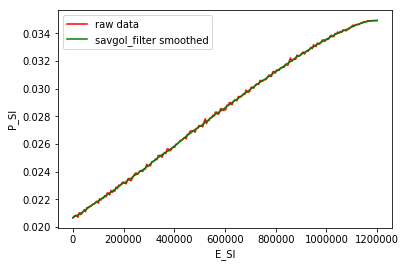

Length of data raws =  240


,E_SI,P_SI,P_smooth
0,0.000000,0.020656,0.020683
1,5020.920502,0.020789,0.020732
2,10041.841004,0.020841,0.020781
3,15062.761506,0.020841,0.020831
4,20083.682008,0.020708,0.020880


In [12]:
### PE的数据可能需要 smooth，所有插入一列
P_upper_fitting = pd.DataFrame()
P_upper_fitting.insert(len(P_upper_fitting.columns), "E_SI", xnew)
P_upper_fitting.insert(len(P_upper_fitting.columns), "P_SI", f(xnew))

P_smooth = savgol_filter(P_upper_fitting["P_SI"], 11, 1)
P_upper_fitting.insert(len(P_upper_fitting.columns), "P_smooth", P_smooth)

plt.plot(P_upper_fitting["E_SI"], P_upper_fitting["P_SI"], 'r-')
plt.plot(P_upper_fitting["E_SI"], P_upper_fitting["P_smooth"], 'g')
plt.xlabel('E_SI')
plt.ylabel('P_SI')
plt.legend(['raw data', 'savgol_filter smoothed'], loc='best')
plt.show()
print('Length of data raws = ',len(P_upper_fitting))
P_upper_fitting.head(5)

#为上一栏调试 smooth 的参数： window size 51, polynomial order 3

x = P_upper_fitting["E_SI"]
y = P_upper_fitting["P_SI"]
yhat = savgol_filter(y, 11, 1) # window size 51, polynomial order 3
print(len(yhat))
plt.plot(x,y)
plt.plot(x,yhat, color='red')
plt.axis([1100000,1200000,0.013,0.015])
plt.show()

# Convert P(E) to P(T)

In [5]:
#从文件名提取温度with regular expression
# path = 'C:\\PhD-Zipeng\\Research projects\\PUND\\BF4 PUND PE Heating\\PECorrected\\Try'
path = 'C:\\PhD-Zipeng\\Research projects\\DABCO\\BF4\\No16_PUND'
files = os.listdir(path)
temperature = list()
for file in files:
    if file.endswith(".csv"):
        num = re.findall(r"\d+.\d+", file)
        temperature.append(float(num[0]))
print(temperature)
len(temperature)

[359.93, 360.05, 360.41, 360.8, 361.17, 361.4, 361.72, 362.03, 362.38, 362.65, 363.04, 363.37, 363.62, 363.96, 364.16, 364.54, 364.75, 364.92, 365.18, 365.41, 365.69, 365.92, 366.19, 366.35, 366.65, 366.91, 367.12, 367.4, 367.63, 367.89, 368.17, 368.4, 368.64, 368.88, 369.1, 369.37, 369.61, 369.91, 370.14, 370.39, 370.58, 370.89, 371.11, 371.37, 371.62, 371.83, 372.08, 372.33, 372.6, 372.82, 373.06, 373.35, 373.53, 373.79, 374.06, 374.3, 374.57, 374.79, 375.07, 375.27, 375.55, 375.77, 376.04, 376.31, 376.47, 376.82, 377.08, 377.25, 377.52, 377.9, 378.06, 378.34, 378.62, 378.88, 379.02, 379.25, 379.64, 379.79, 380.06, 380.29, 380.54, 380.79, 381.0, 381.36, 381.54, 381.84, 381.99, 382.38, 382.46, 382.79, 383.06, 383.32, 383.51, 383.8, 384.01, 384.35, 384.43, 384.8, 384.98, 385.23, 385.44, 385.74, 385.99, 386.22, 386.5, 386.64, 386.96, 387.2, 387.53, 387.73, 387.89, 388.26, 388.44, 388.7, 388.92, 389.22, 389.4, 389.61, 389.96, 390.13, 390.43, 390.63, 390.88, 391.16, 391.39, 391.69, 391.87

140

# 批量操作从此开始
PE 插点> xnew = np.linspace(0, 1200000, num=240, endpoint=True)
插了240个点，每段 0.5kV/cm

In [41]:
## path = 'C:\\PhD-Zipeng\\Research projects\\PUND\\BF4 PUND PE Heating\\PECorrected\\Try'
path = 'C:\\PhD-Zipeng\\Research projects\\DABCO\\BF4\\No16_PUND'
# output_path = 'C:\\PhD-Zipeng\\Research projects\\DABCO\\BF4\\No16_2x42mm2_250um\\PUND indirect\\PE matrix'
files = glob(path + "/*.csv")

P_upper_fitting = pd.DataFrame()
E = np.linspace(0, 1200000, num=241, endpoint=True)
P_upper_fitting.insert(len(P_upper_fitting.columns), "E_SI", E)

i= 0
for file in files:
    df = pd.read_csv(file,delimiter='\,', engine='python')
    index1 = df['Measured Polarization'].idxmax()
    index2 = df['Measured Polarization'].idxmin()
    P_upper = df.loc[index1:index2, [ 'E_SI','Measured Polarization']]
    x = P_upper['E_SI']
    y = P_upper['Measured Polarization']
    f = interp1d(x, y, fill_value="extrapolate",kind='next')
    
#     column_name = str(temperature[i])
    column_name = temperature[i]
    P_upper_fitting.insert(len(P_upper_fitting.columns), column_name, f(E))
    i = i+1
    
print(P_upper_fitting.shape)
print(P_upper_fitting.shape[0],'slice of E')
print(P_upper_fitting.shape[1]-1,'slice of T')
P_upper_fitting.head(50)

# P_upper_fitting.to_csv(output_path+'.csv', index=None)

(241, 141)
241 slice of E
140 slice of T


,E_SI,359.93,360.05,360.41,360.8,361.17,361.4,361.72,362.03,362.38,...,392.9,393.15,393.39,393.67,393.9,394.12,394.37,394.64,394.88,395.08
0,0.0,2.251513,2.231913,2.254779,2.268516,2.262737,2.256371,2.260642,2.275133,2.288534,...,0.156024,0.134973,0.148461,0.172910,0.183855,0.160623,0.141328,0.174035,0.158560,0.179689
1,5000.0,2.244645,2.245147,2.254779,2.268516,2.262737,2.276641,2.268347,2.267092,2.276304,...,0.161602,0.153667,0.154715,0.172910,0.200165,0.177609,0.173290,0.196346,0.177001,0.192044
2,10000.0,2.264412,2.250340,2.246905,2.261312,2.269437,2.276641,2.268347,2.300093,2.279990,...,0.173518,0.147599,0.154715,0.166944,0.200165,0.177609,0.160513,0.201128,0.194427,0.186433
3,15000.0,2.264412,2.250340,2.283927,2.274044,2.284346,2.271279,2.289454,2.292052,2.291214,...,0.167367,0.147599,0.178733,0.166944,0.200165,0.189289,0.160513,0.190802,0.182240,0.198907
4,20000.0,2.270442,2.237106,2.283927,2.284597,2.295235,2.262737,2.285100,2.292052,2.304113,...,0.190269,0.159548,0.184548,0.178370,0.211405,0.183339,0.193016,0.208093,0.201053,0.204281
5,25000.0,2.281499,2.270106,2.269856,2.309725,2.302437,2.284012,2.299004,2.285184,2.312489,...,0.196320,0.172597,0.201602,0.190370,0.217625,0.206022,0.186271,0.208093,0.201053,0.204281
6,30000.0,2.281499,2.256371,2.300847,2.297664,2.288868,2.284012,2.308050,2.316677,2.312489,...,0.184979,0.172597,0.201602,0.185181,0.217625,0.211532,0.212098,0.213028,0.201053,0.235432
7,35000.0,2.292721,2.262401,2.291632,2.297664,2.312823,2.301433,2.308050,2.302773,2.322037,...,0.184979,0.165245,0.190700,0.213831,0.228038,0.217347,0.198542,0.223236,0.213256,0.235432
8,40000.0,2.302437,2.276306,2.291632,2.297664,2.312823,2.320362,2.331670,2.311484,2.329073,...,0.202642,0.196380,0.190700,0.213831,0.238770,0.227454,0.198542,0.223236,0.213256,0.235432
9,45000.0,2.312488,2.292051,2.298836,2.316426,2.312823,2.320362,2.331670,2.321367,2.340966,...,0.218564,0.190564,0.218251,0.207898,0.242235,0.232914,0.205100,0.233396,0.235905,0.241568


# 检测 P over T 在不同电场下是不是正常

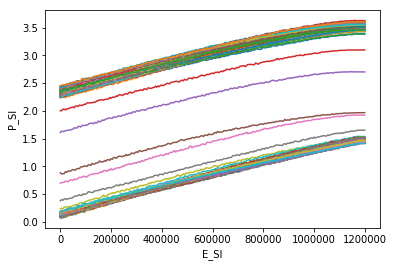

In [42]:
# 检测 P over T 在不同电场下是不是正常
# E = P_upper_fitting.loc[0,temperature[0]:] 
# plt.plot(P_upper_fitting.loc[0,'359.93':])# index0 > E= 0
# plt.plot(P_upper_fitting.loc[240,'359.93':])# index 240 > E= Emax, which is 12 kV/cm
# plt.plot(P_upper_fitting.loc[120,'359.93':])# index 120 > E= 0.5*Emax, which is 6 kV/cm
# plt.show()

# 检测 P over E 在不同温度下是不是正常
i = 0
for j in range(len(temperature)):
    plt.plot(P_upper_fitting['E_SI'], P_upper_fitting[(temperature[i])])
    i = i +1

plt.xlabel('E_SI')
plt.ylabel('P_SI')
plt.show()

P_upper_fitting.to_csv(output_path+'.csv', index=None)

# P_upper 得到以后 construct P(T) at E

In [43]:
P_T = P_upper_fitting.transpose()
P_T.head(5)
# P_T.to_csv('C:\\PhD-Zipeng\\Research projects\\DABCO\\BF4\\No16_2x42mm2_250um\\PUND indirect\\PT matrix2'+'.csv')

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,240
E_SI,0.000000,5000.000000,10000.000000,15000.000000,20000.000000,25000.000000,30000.000000,35000.000000,40000.000000,45000.000000,...,1.155000e+06,1.160000e+06,1.165000e+06,1.170000e+06,1.175000e+06,1.180000e+06,1.185000e+06,1.190000e+06,1.195000e+06,1.200000e+06
359.93,2.251513,2.244645,2.264412,2.264412,2.270442,2.281499,2.281499,2.292721,2.302437,2.312488,...,3.380075e+00,3.388284e+00,3.388284e+00,3.388284e+00,3.385771e+00,3.385771e+00,3.385771e+00,3.385771e+00,3.385771e+00,3.385771e+00
360.05,2.231913,2.245147,2.250340,2.250340,2.237106,2.270106,2.256371,2.262401,2.276306,2.292051,...,3.490804e+00,3.492479e+00,3.493652e+00,3.492982e+00,3.492982e+00,3.492982e+00,3.492982e+00,3.492982e+00,3.492982e+00,3.492982e+00
360.41,2.254779,2.254779,2.246905,2.283927,2.283927,2.269856,2.300847,2.291632,2.291632,2.298836,...,3.387864e+00,3.391382e+00,3.391382e+00,3.387027e+00,3.392219e+00,3.392219e+00,3.392219e+00,3.392219e+00,3.392219e+00,3.392219e+00
360.8,2.268516,2.268516,2.261312,2.274044,2.284597,2.309725,2.297664,2.297664,2.297664,2.316426,...,3.444485e+00,3.444485e+00,3.446663e+00,3.446663e+00,3.446663e+00,3.446998e+00,3.446998e+00,3.446998e+00,3.446998e+00,3.446998e+00


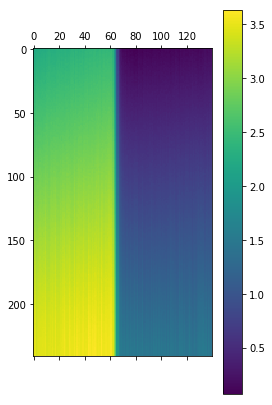

In [44]:
mpl.pyplot.matshow(P_T[1:].transpose(),interpolation='nearest',cmap='viridis')# 省略第一行
# plt.axis([58,70,0,10])
plt.colorbar()
plt.show()

# P_T.to_csv(r'C:\PhD-Zipeng\Research projects\DABCO\BF4\No16_PUND\dS\PET phase diagram_before leakage compensation'+'.csv')

In [45]:
E = P_T.loc["E_SI"]

dPdT_T = P_T.drop(["E_SI"])
dPdT_T.head(5)

,0,1,2,3,4,5,6,7,8,9,...,231,232,233,234,235,236,237,238,239,240
359.93,2.251513,2.244645,2.264412,2.264412,2.270442,2.281499,2.281499,2.292721,2.302437,2.312488,...,3.380075,3.388284,3.388284,3.388284,3.385771,3.385771,3.385771,3.385771,3.385771,3.385771
360.05,2.231913,2.245147,2.250340,2.250340,2.237106,2.270106,2.256371,2.262401,2.276306,2.292051,...,3.490804,3.492479,3.493652,3.492982,3.492982,3.492982,3.492982,3.492982,3.492982,3.492982
360.41,2.254779,2.254779,2.246905,2.283927,2.283927,2.269856,2.300847,2.291632,2.291632,2.298836,...,3.387864,3.391382,3.391382,3.387027,3.392219,3.392219,3.392219,3.392219,3.392219,3.392219
360.80,2.268516,2.268516,2.261312,2.274044,2.284597,2.309725,2.297664,2.297664,2.297664,2.316426,...,3.444485,3.444485,3.446663,3.446663,3.446663,3.446998,3.446998,3.446998,3.446998,3.446998
361.17,2.262737,2.262737,2.269437,2.284346,2.295235,2.302437,2.288868,2.312823,2.312823,2.312823,...,3.454118,3.458641,3.458641,3.460316,3.463833,3.463833,3.463833,3.463833,3.463833,3.463833


359.93
395.08
140


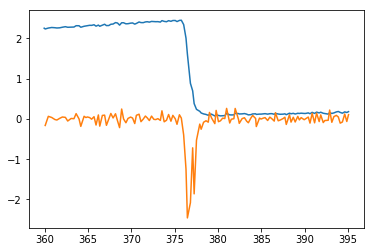

In [46]:
# 做出 T的这个list，因为# dPdT_T.index 的格式不能直接运算，所以新创一个list
i = 0
T = list()
for it in range(len(dPdT_T.index)):
    T.append(dPdT_T.index[i])
    i = i+1
print(min(T))
print(max(T))
print(len(T))

# 看看 P（T）不smooth 的微分效果怎么样，是不是需要平滑
x = T
y = dPdT_T[0]
dx = np.diff(x)
dy = np.diff(y)



plt.plot(y)
plt.plot(x[1:],dy/dx)
plt.show()

# 此处是关键的Gaussian smooth

In [60]:
# 构建一个新的个dataframe, 经过插点和smooth的 PT @ E


Smoothed_PTatE = pd.DataFrame()
T_insert = np.linspace(min(T), max(T), num=140)#插140个点,等比例插点，看之前非pund的 插点的密度
Smoothed_PTatE.insert(len(Smoothed_PTatE.columns), "T", T_insert)

i=0
for row in dPdT_T.iteritems():
    x = T
    y = dPdT_T[i]
    f = interp1d(x, y,kind='cubic')
    y_smooth = gaussian_filter1d(f(T_insert), 6)
    Smoothed_PTatE.insert(len(Smoothed_PTatE.columns), str(i), y_smooth)
    
    i = i+1
    
Smoothed_PTatE.head(5)

,T,0,1,2,3,4,5,6,7,8,...,231,232,233,234,235,236,237,238,239,240
0,359.930000,2.260260,2.262342,2.265144,2.278398,2.280811,2.290602,2.294380,2.298158,2.305940,...,3.440164,3.442785,3.443914,3.442855,3.444568,3.444625,3.445006,3.445006,3.445006,3.445006
1,360.182878,2.260666,2.262744,2.265627,2.278794,2.281301,2.291027,2.294842,2.298648,2.306531,...,3.440742,3.443338,3.444483,3.443429,3.445139,3.445196,3.445579,3.445578,3.445578,3.445578
2,360.435755,2.261467,2.263538,2.266580,2.279576,2.282273,2.291869,2.295755,2.299620,2.307693,...,3.441856,3.444404,3.445581,3.444535,3.446241,3.446298,3.446681,3.446681,3.446681,3.446681
3,360.688633,2.262643,2.264710,2.267977,2.280728,2.283711,2.293110,2.297102,2.301057,2.309390,...,3.443428,3.445908,3.447129,3.446096,3.447795,3.447852,3.448235,3.448235,3.448235,3.448235
4,360.941511,2.264166,2.266236,2.269783,2.282227,2.285591,2.294727,2.298857,2.302936,2.311568,...,3.445351,3.447745,3.449021,3.448004,3.449694,3.449751,3.450131,3.450130,3.450130,3.450130


In [61]:
Smoothed_PTatE.to_csv(r'C:\PhD-Zipeng\Research projects\DABCO\BF4\No16_PUND\dS\Smoothed_PTatE_gaussian 6_NOcompensation'+'.csv')
# dPdT_T.to_csv(r'C:\PhD-Zipeng\Research projects\DABCO\BF4\No16_PUND\dS\Nosmooth_PTatE_Nocompensation'+'.csv')

# 对PT @ E 做插点和smooth

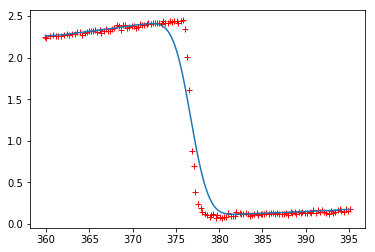

In [48]:
plt.plot(T,dPdT_T[0],'r+')
plt.plot(Smoothed_PTatE["T"],Smoothed_PTatE["1"])
plt.show()

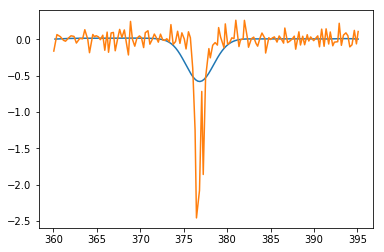

In [49]:
####单列求dP/dT
#### 下面对所有列批量操作

i = 1
x = Smoothed_PTatE["T"]
y = Smoothed_PTatE["1"]

dx = np.diff(x)
dy = np.diff(y)
dydx = dy/dx

plt.plot(x[1:],dydx)

#smooth 之前的数据，做比较
plt.plot(T[1:],  np.diff(dPdT_T[0])/np.diff(T))

plt.show()

In [50]:
### 批量操作求dP/dT
dPdT_diff = pd.DataFrame()
x = Smoothed_PTatE["T"] 
dx = np.diff(x)


i = 0
for row in range(len(Smoothed_PTatE.columns)-1):
    y = Smoothed_PTatE[str(i)]
    dy = np.diff(y)
    dydx = dy/dx
# #     column_name = str(temperature[i])
    dPdT_diff.insert(len(dPdT_diff.columns), str(i), pd.Series(dydx))
    i = i+1
    
dPdT_diff.insert(0, "T", x)
dPdT_diff.head(400)

,T,0,1,2,3,4,5,6,7,8,...,231,232,233,234,235,236,237,238,239,240
0,359.930000,0.001604,0.001588,0.001910,0.001564,0.001939,0.001681,0.001824,0.001940,0.002336,...,0.002284,0.002186,0.002250,0.002268,0.002260,0.002259,0.002263,0.002263,0.002263,0.002263
1,360.182878,0.003166,0.003141,0.003767,0.003093,0.003844,0.003328,0.003610,0.003843,0.004596,...,0.004405,0.004216,0.004340,0.004375,0.004358,0.004356,0.004361,0.004360,0.004360,0.004360
2,360.435755,0.004652,0.004634,0.005525,0.004558,0.005686,0.004909,0.005327,0.005683,0.006711,...,0.006217,0.005946,0.006122,0.006172,0.006145,0.006144,0.006144,0.006143,0.006143,0.006143
3,360.688633,0.006023,0.006035,0.007144,0.005926,0.007435,0.006393,0.006939,0.007427,0.008616,...,0.007605,0.007266,0.007484,0.007545,0.007509,0.007510,0.007498,0.007497,0.007497,0.007497
4,360.941511,0.007259,0.007328,0.008590,0.007168,0.009056,0.007758,0.008420,0.009047,0.010268,...,0.008529,0.008139,0.008383,0.008457,0.008411,0.008415,0.008386,0.008384,0.008384,0.008384
5,361.194388,0.008348,0.008505,0.009845,0.008262,0.010522,0.008989,0.009744,0.010526,0.011632,...,0.008972,0.008545,0.008802,0.008889,0.008836,0.008845,0.008794,0.008791,0.008791,0.008791
6,361.447266,0.009285,0.009557,0.010904,0.009191,0.011811,0.010074,0.010897,0.011842,0.012697,...,0.008990,0.008541,0.008796,0.008900,0.008844,0.008861,0.008787,0.008782,0.008782,0.008782
7,361.700144,0.010068,0.010482,0.011759,0.009940,0.012891,0.011002,0.011856,0.012971,0.013460,...,0.008659,0.008201,0.008440,0.008570,0.008515,0.008542,0.008447,0.008442,0.008442,0.008442
8,361.953022,0.010712,0.011277,0.012416,0.010503,0.013744,0.011771,0.012616,0.013894,0.013934,...,0.008110,0.007655,0.007865,0.008031,0.007981,0.008022,0.007913,0.007905,0.007905,0.007905
9,362.205899,0.011223,0.011942,0.012888,0.010880,0.014348,0.012377,0.013167,0.014590,0.014143,...,0.007478,0.007036,0.007207,0.007421,0.007378,0.007434,0.007321,0.007311,0.007311,0.007311


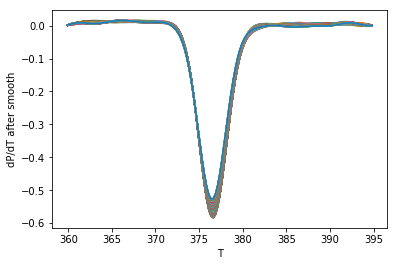

In [51]:
# dP/dT over T, 看看形状对不对

i = 0
for j in range(len(dPdT_diff.columns)-1):
    plt.plot(dPdT_diff['T'], dPdT_diff[str(i)])
    i = i +1

plt.xlabel('T')
plt.ylabel('dP/dT after smooth')
# plt.axis([375,379,-0.0045,-0.00576])
plt.show()

In [55]:
dPdT_trans = dPdT_diff.transpose()

# print(dPdT_trans.head(10))
dPdT_trans = dPdT_trans.drop(["T"])
dPdT_trans.insert(0, "E", np.linspace(0, 1200000, num=241, endpoint=True))
dPdT_trans.head(250)

,E,0,1,2,3,4,5,6,7,8,...,129,130,131,132,133,134,135,136,137,138
0,0.0,0.001604,0.003166,0.004652,0.006023,0.007259,0.008348,0.009285,0.010068,0.010712,...,0.004677,0.005027,0.005286,0.005384,0.005271,0.004916,0.004311,0.003470,2.433958e-03,0.001254
1,5000.0,0.001588,0.003141,0.004634,0.006035,0.007328,0.008505,0.009557,0.010482,0.011277,...,0.006679,0.007373,0.007863,0.008062,0.007909,0.007374,0.006461,0.005193,3.635863e-03,0.001874
2,10000.0,0.001910,0.003767,0.005525,0.007144,0.008590,0.009845,0.010904,0.011759,0.012416,...,0.004440,0.005244,0.005930,0.006385,0.006518,0.006277,0.005637,0.004618,3.276524e-03,0.001701
3,15000.0,0.001564,0.003093,0.004558,0.005926,0.007168,0.008262,0.009191,0.009940,0.010503,...,0.003109,0.003587,0.004002,0.004277,0.004353,0.004187,0.003762,0.003082,2.186602e-03,0.001138
4,20000.0,0.001939,0.003844,0.005686,0.007435,0.009056,0.010522,0.011811,0.012891,0.013744,...,0.006797,0.007421,0.007821,0.007937,0.007717,0.007144,0.006226,0.004985,3.481256e-03,0.001792
5,25000.0,0.001681,0.003328,0.004909,0.006393,0.007758,0.008989,0.010074,0.011002,0.011771,...,0.005592,0.005752,0.005792,0.005674,0.005365,0.004862,0.004164,0.003294,2.279708e-03,0.001168
6,30000.0,0.001824,0.003610,0.005327,0.006939,0.008420,0.009744,0.010897,0.011856,0.012616,...,0.004897,0.005346,0.005724,0.005943,0.005926,0.005621,0.005004,0.004076,2.883878e-03,0.001494
7,35000.0,0.001940,0.003843,0.005683,0.007427,0.009047,0.010526,0.011842,0.012971,0.013894,...,0.005185,0.005635,0.005995,0.006184,0.006131,0.005786,0.005127,0.004164,2.939891e-03,0.001522
8,40000.0,0.002336,0.004596,0.006711,0.008616,0.010268,0.011632,0.012697,0.013460,0.013934,...,0.004604,0.005037,0.005356,0.005492,0.005399,0.005047,0.004433,0.003571,2.505745e-03,0.001294
9,45000.0,0.001789,0.003533,0.005194,0.006729,0.008112,0.009328,0.010363,0.011211,0.011872,...,0.005525,0.006081,0.006522,0.006758,0.006709,0.006330,0.005603,0.004542,3.201800e-03,0.001657


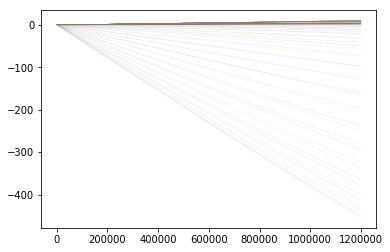

,E,0,1,2,3,4,5,6,7,8,...,129,130,131,132,133,134,135,136,137,138
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,5000.0,7.980660,15.766418,23.213218,30.146963,36.467811,42.132801,47.104500,51.375653,54.972215,...,28.390362,31.001191,32.871122,33.615332,32.950327,30.727089,26.930809,21.657018,15.174552,7.821196
2,10000.0,16.726242,33.035074,48.609895,63.096072,76.264390,88.007724,98.256347,106.978076,114.204446,...,56.186783,62.542499,67.352534,69.732022,69.018027,64.856086,57.176159,46.183730,32.455519,16.759931
3,15000.0,25.410463,50.183786,73.817378,95.770630,115.660139,133.276274,148.494605,161.224640,171.501790,...,75.057938,84.618404,92.183619,96.385488,96.194187,91.016258,80.673969,65.433647,46.113335,23.857671
4,20000.0,34.166828,67.525816,99.428193,129.171537,156.219174,180.237190,201.001123,218.301612,232.118735,...,99.823808,112.137906,121.743505,126.918408,126.369310,119.343323,105.643170,85.600611,60.282979,31.181554
5,25000.0,43.217879,85.457341,125.917200,163.741208,198.253676,229.015188,255.714647,278.033872,295.906267,...,130.796316,145.069887,155.777514,160.944685,159.076000,149.357254,131.618164,106.298634,74.685387,38.580136
6,30000.0,51.982649,102.804192,151.508256,197.072291,238.698881,275.848561,308.143751,335.179257,356.873188,...,157.017039,172.815108,184.566752,189.987045,187.304359,175.564229,154.538989,124.724548,87.594353,45.235507
7,35000.0,61.394977,121.437755,179.034640,232.988999,282.366695,326.525078,364.993063,397.246877,423.147436,...,182.221442,200.267789,213.863320,220.305500,217.447300,204.081092,179.868137,145.325541,102.153776,52.776050
8,40000.0,72.087219,142.534535,210.019078,273.097256,330.653605,381.921896,426.342000,463.323511,492.716501,...,206.694816,226.948431,242.239952,249.497760,246.273607,231.163463,203.770131,164.663607,115.767867,59.816429
9,45000.0,82.400829,162.856075,239.779136,311.460585,376.602132,434.323091,483.992975,525.000647,557.231145,...,232.018732,254.744875,271.934224,280.123817,276.544926,259.606514,228.860229,184.945081,130.036730,67.194245


In [56]:
dPdT_inteE = pd.DataFrame()
# dPdT_inteE.insert(len(inteE.columns), str(i), pd.Series(dydx))


i = 0 

for j in range(139):
    x = dPdT_trans['E']
    y = dPdT_trans[i]
    y_integration = integrate.cumtrapz(y, x, initial=0)
    dPdT_inteE.insert(len(dPdT_inteE.columns), str(i), pd.Series(y_integration))
    # print(y_integration)
    plt.plot(x,y_integration/1496, linestyle='dashed',linewidth=0.1, markersize=1)
    i = i+1
plt.show()
dPdT_inteE.insert(0, "E", np.linspace(0, 1200000, num=241, endpoint=True))
dPdT_inteE.head(300)


In [57]:
dPdT_final = dPdT_inteE.transpose()
# print(dPdT_inteE.head(10))
dPdT_final = dPdT_final.drop(["E"])
# dPdT_inteE.head(400)
dPdT_final.insert(0, "T",T_insert[:-1])
# print(T_insert[:-1])
dPdT_final.head(400)

,T,0,1,2,3,4,5,6,7,8,...,231,232,233,234,235,236,237,238,239,240
0,359.930000,0.0,7.980660,16.726242,25.410463,34.166828,43.217879,51.982649,61.394977,72.087219,...,2098.540318,2109.714339,2120.804812,2132.101423,2143.422352,2154.720422,2166.026192,2177.341107,2188.655455,2199.969804
1,360.182878,0.0,15.766418,33.035074,50.183786,67.525816,85.457341,102.804192,121.437755,142.534535,...,4105.749205,4127.300207,4148.689880,4170.477681,4192.309592,4214.094778,4235.887862,4257.690868,4279.492610,4301.294353
2,360.435755,0.0,23.213218,48.609895,73.817378,99.428193,125.917200,151.508256,179.034640,210.019078,...,5934.991440,5965.398194,5995.569533,6026.305517,6057.099206,6087.823915,6118.545145,6149.263279,6179.979321,6210.695364
3,360.688633,0.0,30.146963,63.096072,95.770630,129.171537,163.741208,197.072291,232.988999,273.097256,...,7522.304802,7559.483088,7596.358461,7633.931226,7671.567637,7709.115156,7746.635002,7784.121848,7821.605260,7859.088671
4,360.941511,0.0,36.467811,76.264390,115.660139,156.219174,198.253676,238.698881,282.366695,330.653605,...,8834.863547,8876.534034,8917.839675,8959.939036,9002.107772,9044.172526,9086.173877,9128.096699,9170.014324,9211.931949
5,361.194388,0.0,42.132801,88.007724,133.276274,180.237190,229.015188,275.848561,326.525078,381.921896,...,9852.392580,9896.187252,9939.556896,9983.784923,10028.097114,10072.300810,10116.399414,10160.362193,10204.317455,10248.272716
6,361.447266,0.0,47.104500,98.256347,148.494605,201.001123,255.714647,308.143751,364.993063,426.342000,...,10590.622894,10634.448663,10677.790682,10722.030484,10766.389939,10810.652234,10854.771481,10898.694307,10942.606511,10986.518717
7,361.700144,0.0,51.375653,106.978076,161.224640,218.301612,278.033872,335.179257,397.246877,463.323511,...,11082.978982,11125.128610,11166.731967,11209.256079,11251.966689,11294.608911,11337.082840,11379.305131,11421.512963,11463.720791
8,361.953022,0.0,54.972215,114.204446,171.501790,232.118735,295.906267,356.873188,423.147436,492.716501,...,11383.083911,11422.496779,11461.298576,11501.039994,11541.070061,11581.075623,11620.911082,11660.455467,11699.980899,11739.506339
9,362.205899,0.0,57.911047,119.984450,179.403287,242.474274,309.287507,373.147214,442.540007,514.373421,...,11551.706213,11587.992686,11623.601819,11660.172539,11697.170063,11734.200726,11771.087944,11807.667262,11844.222418,11880.777531


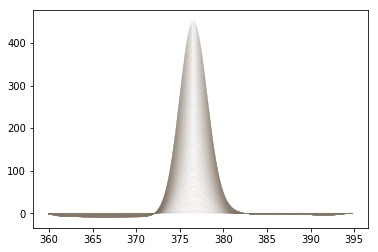

In [58]:
#这是 gaussina 6 出来的结果，只是为了和下面做对比

i = 0 

for j in range(240):
    x = dPdT_final['T']
    y = dPdT_final[i]
    plt.plot(x,y/-1496, linestyle='dashed',linewidth=0.1, markersize=1)
    i = i+1
plt.show()

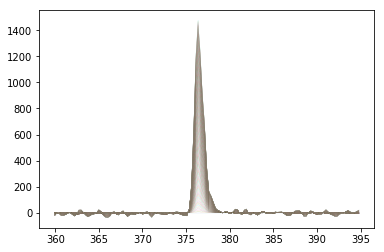

In [39]:
i = 0 

for j in range(240):
    x = dPdT_final['T']
    y = dPdT_final[i]
    plt.plot(x,y/-1496, linestyle='dashed',linewidth=0.1, markersize=1)
    i = i+1
plt.show()

In [59]:
dPdT_final.to_csv(r'C:\PhD-Zipeng\Research projects\DABCO\BF4\No16_PUND\dS\dS_volume_heating_Guassian 6_NOcompensation'+'.csv')

# 
P_upper_fitting

>transpose>

P_T

>drop ["E_SI']>

dPdT_T

>Smooth>

Smoothed_PTatE

>dy = np.diff(y)>

dPdT_diff

>transpose>

dPdT_inteE 

>integrate.cumtrapz(y, x, initial=0)>

dPdT_final

>transpose>